In [114]:

from scipy.optimize import curve_fit
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
import warnings
from scipy.stats import pearsonr
from scipy.signal import argrelmax
import matplotlib.colors as colors
import pymannkendall as mk
import matplotlib.cm as cmx

In [115]:
directory = '../data/PROCESSED'

In [116]:
def get_time_ticks(times):
    seconds = [t.second for t in times]
    hours = [t.hour for t in times]
    minutes = [t.minute for t in times]
    time_ticks = [f'{h}:{str(m).zfill(2)}:{str(s).zfill(2)}' for h,m,s in zip(hours, minutes, seconds)]
    return time_ticks

In [117]:
freqname = 'Ka'
polname = 'hv'

In [118]:
# 1300 descent begins
# 1508 the sweep beg

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: KuKa combined echo and summary data
    file_processed_with: KuKaPy translated from ProSensing IDL code by Vishnu Nandan with additions by Rosemary Willatt, Thomas Newman and Robbie Mallett
    date_created: 20230818
    data_type: KuKaPy output
    current_calibration_loop_power: 0.0022556179860772005
    n_groups: 1158
    n_blocks_per_group: 1
    dimensions(sizes): sample(1158), range(4096), pol(4)
    variables(dimensions): |S1 polarisation(pol), float64 along_tilt(sample), float64 cross_tilt(sample), float64 start_time(sample), float64 lat(sample), float64 lon(sample), float64 range(range), float64 vv_power_decon0(range, sample), float64 hv_power_decon0(range, sample), float64 vh_power_decon0(range, sample), float64 hh_power_decon0(range, sample), float64 range_peak_signal_decon0(sample), float64 nrcs_decon0(pol, sample), float64 rho_hv_vec_decon0(sample), float64 phase_hv_deg_vec_dec

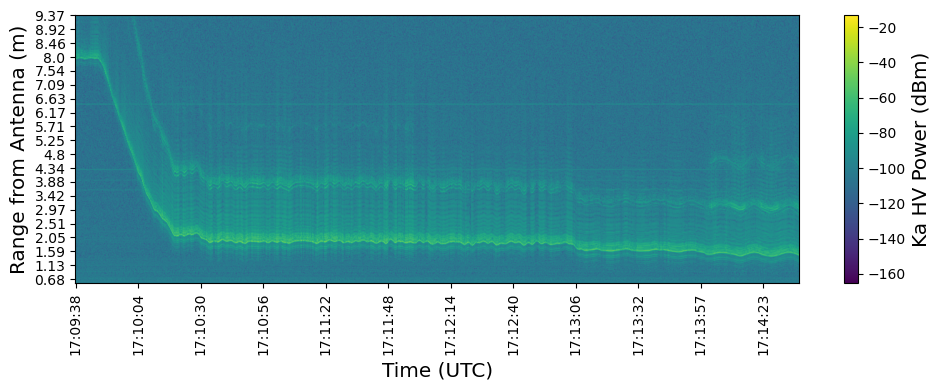

In [119]:
skipper = 100

if 'a' in freqname:
    ylims = (2500,570)
else:
    ylims = (2000,400)
    
if freqname == 'Ku':
    f = 'kuka_stare_decon_Ku-Scat20230608-170939.nc'
elif freqname == 'Ka':
    f = 'kuka_stare_decon_Ka-Scat20230608-170938.nc'
else: raise

with Dataset(f'../data/PROCESSED/20230608/height_ex/{f}') as d:
    ranges = np.array(d['range'])
    times = [datetime.datetime(1970,1,1)+datetime.timedelta(seconds=float(x)) for x in d['start_time']]

    time_ticks = get_time_ticks(times)

    p = np.array(d[f'{polname}_power_decon0'])
    
    plt.figure(figsize=(10,4))
    plt.imshow(10*np.log10(p),aspect='auto')
    plt.xticks(np.arange(0,p.shape[1],skipper),labels=time_ticks[::skipper],rotation=90)

    plt.yticks(np.arange(0,p.shape[0],skipper),labels=[str(round(x,2)) for x in ranges[::skipper]])

    cb = plt.colorbar()
    cb.set_label(f'{freqname} {polname.upper()} Power (dBm)',fontsize='x-large')
    
    plt.ylabel('Range from Antenna (m)',fontsize='x-large')
    plt.xlabel('Time (UTC)',fontsize='x-large')
    
    plt.ylim(ylims[1],ylims[0])
    
    print(d)
#     plt.show()
    

range_res = np.diff(ranges)[0]
window_ranges = np.arange(-10*range_res,10*range_res+1e-10,range_res)

plt.tight_layout()

plt.savefig(f'../figures/echogram_{freqname}_{polname}.jpg',dpi=600)

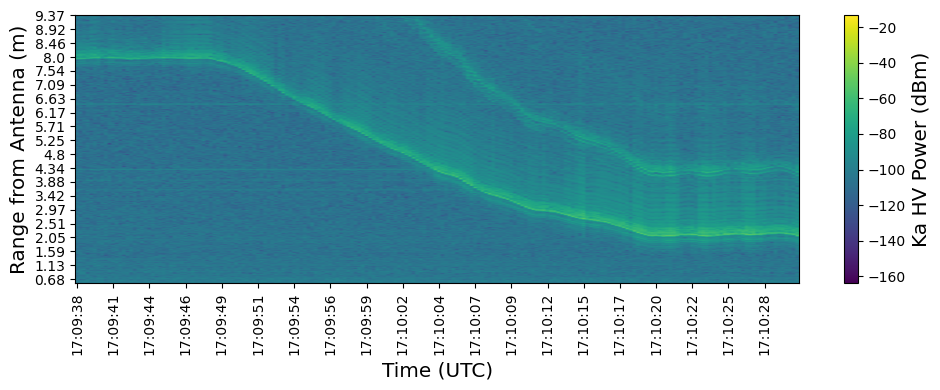

In [120]:
skipper = 100

if freqname == 'Ka':
    time_lim = 200
    ylims = (2500,570)
elif freqname == 'Ku':
    time_lim = 100
    ylims = (2000,400)



with Dataset(f'../data/PROCESSED/20230608/height_ex/{f}') as d:
    ranges = np.array(d['range'])
    times = [datetime.datetime(1970,1,1)+datetime.timedelta(seconds=float(x)) for x in d['start_time']]

    time_ticks = get_time_ticks(times)[:time_lim]

    p = np.array(d[f'{polname}_power_decon0'])[:,:time_lim]
    
    plt.figure(figsize=(10,4))
    plt.imshow(10*np.log10(p),aspect='auto')
    plt.xticks(np.arange(0,p.shape[1],10),labels=time_ticks[::10],rotation=90)

    plt.yticks(np.arange(0,p.shape[0],skipper),labels=[str(round(x,2)) for x in ranges[::skipper]])

    cb = plt.colorbar()
    cb.set_label(f'{freqname} {polname.upper()} Power (dBm)',fontsize='x-large')
    
    plt.ylabel('Range from Antenna (m)',fontsize='x-large')
    plt.xlabel('Time (UTC)',fontsize='x-large')
    
    atilt = np.array(d['along_tilt'])
    ctilt = np.array(d['cross_tilt'])
    
    plt.ylim(ylims[1],ylims[0])
#     plt.show()
    

range_res = np.diff(ranges)[0]
window_ranges = np.arange(-10*range_res,10*range_res+1e-10,range_res)

plt.tight_layout()

plt.savefig(f'../figures/echogram_closeup_{freqname}_{polname}.jpg',dpi=600)

In [121]:
range_mask = np.ones(ranges.shape[0])

range_mask[ranges<1.5] = 0
range_mask[ranges>8.6] = 0

range_mask_2d = np.repeat([range_mask],p.shape[1],axis=0).T

hhm = p*range_mask_2d*1000

argmax = np.argmax(hhm,axis=0)

max_ranges = ranges[argmax]

max_powers = np.max(hhm,axis=0)

window_size=10


x = np.linspace(window_ranges[0],window_ranges[-1],100)

peaks = []
fwhms = []
atilts = []
ctilts = []

a,b = 25,time_lim

for i in range(a,b):

    max_power_range_ind = argmax[i]
    
    peak = hhm[max_power_range_ind-window_size:max_power_range_ind+window_size+1,i]
    

    poly = np.polyfit(window_ranges,peak,deg=13)
    s = np.poly1d(poly)
    y = s(x)
    polypeakargmax = np.argmax(y)
    polypeakmax = np.max(y)
    fwhm = x[polypeakargmax + np.argmin(y[polypeakargmax:]>polypeakmax/2)] - x[np.argmax(y>polypeakmax/2)]
    

    peaks.append(peak)
    fwhms.append(fwhm)
    atilts.append(atilt[i])
    ctilts.append(ctilt[i])
    
jet = cm = plt.get_cmap('rainbow') 
cNorm  = colors.Normalize(vmin=2, vmax=np.max(np.array(max_ranges).flatten()))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

dt0 = times[0]

secs = [(t-dt0).seconds + (t-dt0).microseconds*1e-6 for t in times]

# Make an example plot of a peak

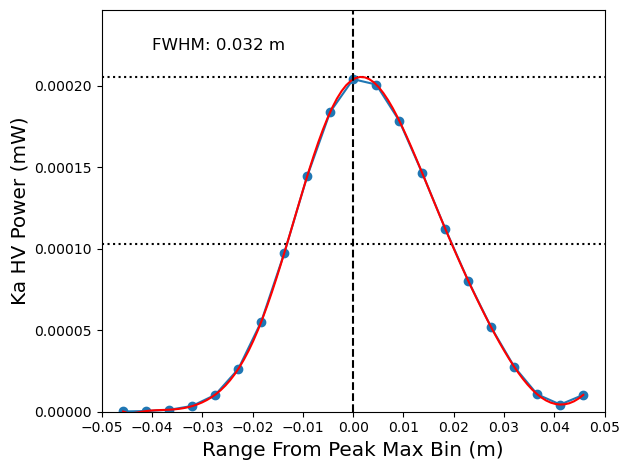

In [122]:
i = 0

max_power_range_ind = argmax[i]

# peak = hhm[max_power_range_ind-window_size:max_power_range_ind+window_size+1,i]

# peak = peaks[i]

poly = np.polyfit(window_ranges,peaks[i],deg=13)
s = np.poly1d(poly)
x = np.linspace(window_ranges[0],window_ranges[-1],100)
y = s(x)
polypeakargmax = np.argmax(y)
polypeakmax = np.max(y)
fwhm = x[polypeakargmax + np.argmin(y[polypeakargmax:]>polypeakmax/2)] - x[np.argmax(y>polypeakmax/2)]

plt.axhline(np.max(y),color='k',ls=':')
plt.axhline(np.max(y)/2,color='k',ls=':')
plt.ylim(0,np.max(y)*1.2)
plt.xlim(-0.05,0.05)

plt.plot(window_ranges,peaks[i],marker='o')

plt.plot(x,y,color='r')

plt.ylabel(f'{freqname} {polname.upper()} Power (mW)',fontsize='x-large')
plt.xlabel('Range From Peak Max Bin (m)',fontsize='x-large')
plt.xticks(np.arange(-0.05,0.051,0.01))
plt.axvline(0,ls='--',color='k')
plt.annotate(f'FWHM: {np.round(fwhm,3)} m',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
plt.tight_layout()
# plt.savefig(f'../figures/Peaks.jpg',dpi=600)

In [123]:
dd = {'power':max_powers[a:b],
      'range':max_ranges[a:b],
      'atilt':atilts,
      'ctilt':ctilts,
      'fwhm':fwhms}

df = pd.DataFrame(dd)

df['ttilt'] = np.degrees(np.sqrt(np.radians(df['ctilt'])**2 + np.radians(df['atilt'])**2))

df

,power,range,atilt,ctilt,fwhm,ttilt
0,0.000204,7.973335,-3.731212,-3.370869,0.032367,5.028389
1,0.000156,7.968757,-3.731212,-3.370869,0.026818,5.028389
2,0.000245,7.959602,-3.731212,-3.370869,0.024969,5.028389
3,0.000232,7.955024,-4.293023,-3.040392,0.026818,5.260611
4,0.000163,7.955024,-4.293023,-3.040392,0.037916,5.260611
...,...,...,...,...,...,...
170,0.001484,2.187202,-5.009058,-2.093023,0.023119,5.428757
171,0.002583,2.178047,-5.009058,-2.093023,0.024044,5.428757
172,0.001346,2.159736,-4.138801,-1.630355,0.026818,4.448340
173,0.001350,2.136848,-4.138801,-1.630355,0.030518,4.448340


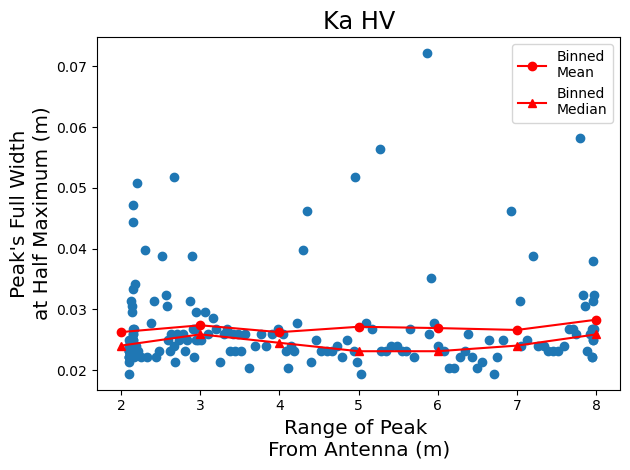

In [124]:
plt.scatter(df['range'],df['fwhm'])

stat = binned_statistic(df['range'],df['fwhm'],'mean',bins=np.arange(1.5,8.51,1))
plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='o',label='Binned\nMean')

stat = binned_statistic(df['range'],df['fwhm'],'median',bins=np.arange(1.5,8.51,1))
plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='^',label='Binned\nMedian')

plt.ylabel("Peak's Full Width\nat Half Maximum (m)",fontsize='x-large')
plt.xlabel("Range of Peak \nFrom Antenna (m)",fontsize='x-large')

plt.title(f'{freqname} {polname.upper()}',fontsize='xx-large')

plt.legend()

plt.tight_layout()

plt.savefig(f'../figures/fwhm_vs_range_{freqname}_{polname}.jpg',dpi=600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


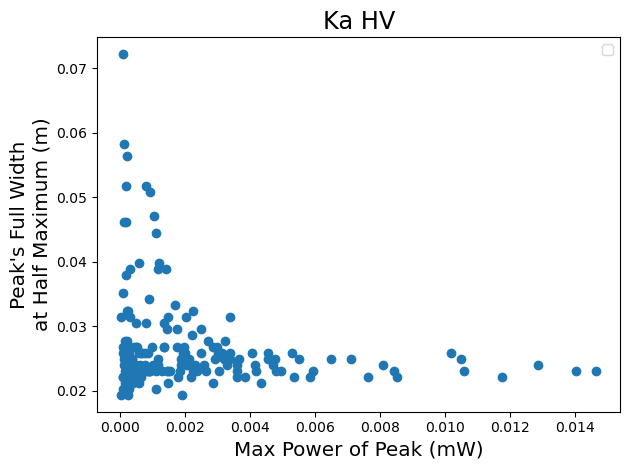

In [125]:
plt.scatter(df['power'],df['fwhm'])

# stat = binned_statistic(df['power'],df['fwhm'],'mean',bins=np.arange(1.5,8.51,1))
# plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='o',label='Binned\nMean')

# stat = binned_statistic(df['power'],df['fwhm'],'median',bins=np.arange(1.5,8.51,1))
# plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='^',label='Binned\nMedian')

plt.ylabel("Peak's Full Width\nat Half Maximum (m)",fontsize='x-large')
plt.xlabel("Max Power of Peak (mW)",fontsize='x-large')

plt.title(f'{freqname} {polname.upper()}',fontsize='xx-large')

plt.legend()

plt.tight_layout()

plt.savefig(f'../figures/fwhm_vs_power_{freqname}_{polname}.jpg',dpi=600)

# ^ Key point of this is that wide peaks are exclusively weak, and powerful peaks are exclusively narrow. But most peaks are weak & narrow.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


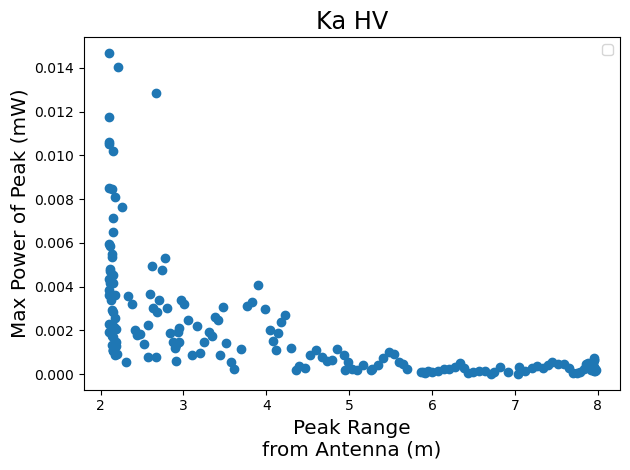

In [126]:


plt.scatter(df['range'],df['power'])

# stat = binned_statistic(df['power'],df['fwhm'],'mean',bins=np.arange(1.5,8.51,1))
# plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='o',label='Binned\nMean')

# stat = binned_statistic(df['power'],df['fwhm'],'median',bins=np.arange(1.5,8.51,1))
# plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='^',label='Binned\nMedian')

plt.xlabel("Peak Range\nfrom Antenna (m)",fontsize='x-large')
plt.ylabel("Max Power of Peak (mW)",fontsize='x-large')

plt.title(f'{freqname} {polname.upper()}',fontsize='xx-large')

plt.legend()

plt.tight_layout()

plt.savefig(f'../figures/power_vs_range_{freqname}_{polname}.jpg',dpi=600)

# ^ Key point of this is that at far range peaks are exclusively weak. And very powerful peaks occur exclusively at near range. 

In [127]:
dfmk = pd.DataFrame({'r':df['range'],'w':df['fwhm']})
dfmk.sort_values('r',inplace=True)

result = mk.original_test(dfmk['w'])
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.2240825711618477, z=1.2157437010597132, Tau=0.06180623973727422, s=941.0, var_s=597821.6666666666, slope=7.796510004390144e-20, intercept=0.02496892755681817)


# Now address issue of specular reflections and radar tilt

In [128]:
df

,power,range,atilt,ctilt,fwhm,ttilt
0,0.000204,7.973335,-3.731212,-3.370869,0.032367,5.028389
1,0.000156,7.968757,-3.731212,-3.370869,0.026818,5.028389
2,0.000245,7.959602,-3.731212,-3.370869,0.024969,5.028389
3,0.000232,7.955024,-4.293023,-3.040392,0.026818,5.260611
4,0.000163,7.955024,-4.293023,-3.040392,0.037916,5.260611
...,...,...,...,...,...,...
170,0.001484,2.187202,-5.009058,-2.093023,0.023119,5.428757
171,0.002583,2.178047,-5.009058,-2.093023,0.024044,5.428757
172,0.001346,2.159736,-4.138801,-1.630355,0.026818,4.448340
173,0.001350,2.136848,-4.138801,-1.630355,0.030518,4.448340


(4.0, 7.0)

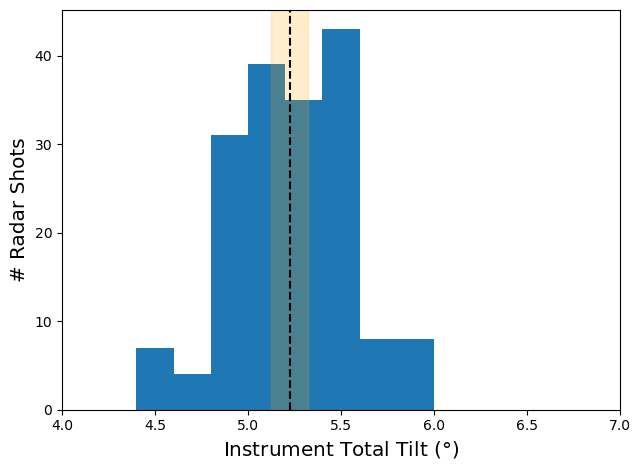

In [140]:
band_width = 0.1

plt.hist(df['ttilt'],bins=np.arange(1,6.5,0.2))
plt.axvline(np.nanmean(df['ttilt']),color='k',ls='--')
plt.axvspan(np.nanmean(df['ttilt'])-band_width,np.nanmean(df['ttilt'])+band_width,color='orange',alpha=0.2)
plt.xlabel('Instrument Total Tilt ($\degree$)',fontsize='x-large')
plt.ylabel('# Radar Shots',fontsize='x-large')
plt.tight_layout()
plt.xlim(4,7)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


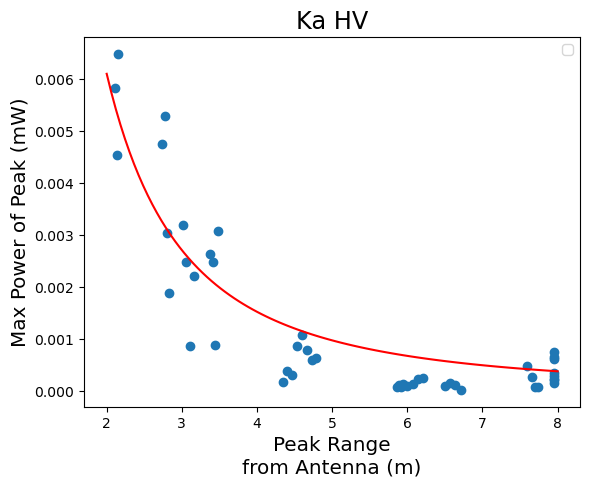

In [141]:
df_ = df[np.abs(df['ttilt']-np.nanmean(df['ttilt'])) < band_width]

plt.scatter(df_['range'],df_['power'])

x = np.linspace(2,8,100)

def funcinv(x, a, b):
    return b + a/(x**2)

bounds = ([0,0],[np.inf,np.inf])

popt, pcov = curve_fit(funcinv, df_['range'],df_['power'],
                       bounds=bounds,
                      )

y = popt[1] + popt[0]/(x**2)

plt.plot(x,y,color='r')

# stat = binned_statistic(df['power'],df['fwhm'],'mean',bins=np.arange(1.5,8.51,1))
# plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='o',label='Binned\nMean')

# stat = binned_statistic(df['power'],df['fwhm'],'median',bins=np.arange(1.5,8.51,1))
# plt.plot([2,3,4,5,6,7,8],stat[0],color='r',marker='^',label='Binned\nMedian')

plt.xlabel("Peak Range\nfrom Antenna (m)",fontsize='x-large')
plt.ylabel("Max Power of Peak (mW)",fontsize='x-large')

plt.title(f'{freqname} {polname.upper()}',fontsize='xx-large')

plt.legend()

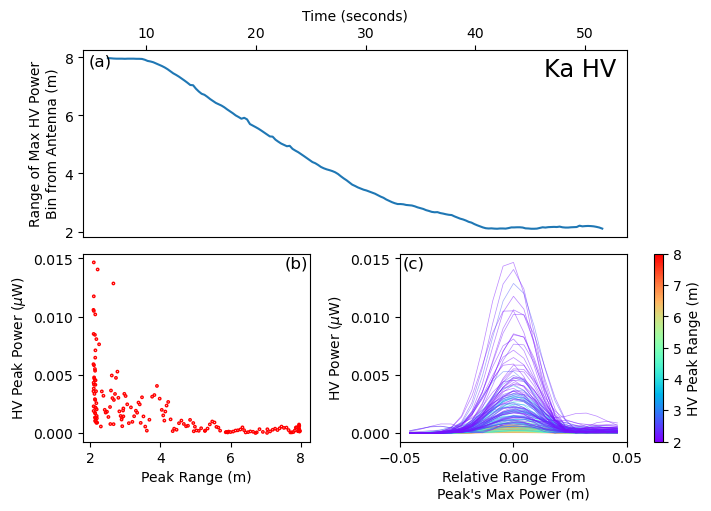

In [131]:
fig = plt.figure(constrained_layout=True,figsize=(7,5))

gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1:, -1])


ax1.plot(secs[a:b],max_ranges[a:b])
# ax1.set_xticks(dt_ticks)
ax1.set_ylabel('Range of Max HV Power\nBin from Antenna (m)')
ax1.set_xlabel('Time (seconds)')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 


ax2.scatter(max_ranges[a:b],max_powers[a:b],marker='o',facecolors='none',edgecolors='r',s=3)

ax2.set_ylabel(f'{polname.upper()} Peak Power ($\mu$W)')
ax2.set_xlabel('Peak Range (m)')


for pe, m in zip(peaks,max_ranges[a:b]):
    
    colorVal = scalarMap.to_rgba(m)
    
    ax3.plot(window_ranges,np.array(pe),color=colorVal,alpha=0.5,lw=0.5)

ax3.set_xlabel("Relative Range From\nPeak's Max Power (m)")
ax3.set_xlim(-0.05,0.05)
ax3.set_xticks([-0.05,0,0.05])
ax3.set_ylabel(f'{polname.upper()} Power ($\mu$W)')
    
cb = fig.colorbar(scalarMap,ax=ax3)
cb.set_ticks(np.arange(2,8.01,1))
cb.set_label(f'{polname.upper()} Peak Range (m)')

ax1.annotate('(a)',xycoords='axes fraction',xy=(0.01,0.98),va='top',fontsize='large')
ax1.annotate(f'{freqname} {polname.upper()}',xycoords='axes fraction',xy=(0.98,0.96),va='top',ha='right',fontsize='xx-large')
ax2.annotate('(b)',xycoords='axes fraction',xy=(0.99,0.99),ha='right',va='top',fontsize='large')
ax3.annotate('(c)',xycoords='axes fraction',xy=(0.01,0.99),va='top',fontsize='large')

plt.savefig(f'../figures/Pancakes_in_swell_crane_{freqname}_{polname}.jpg',dpi=500)

plt.show()



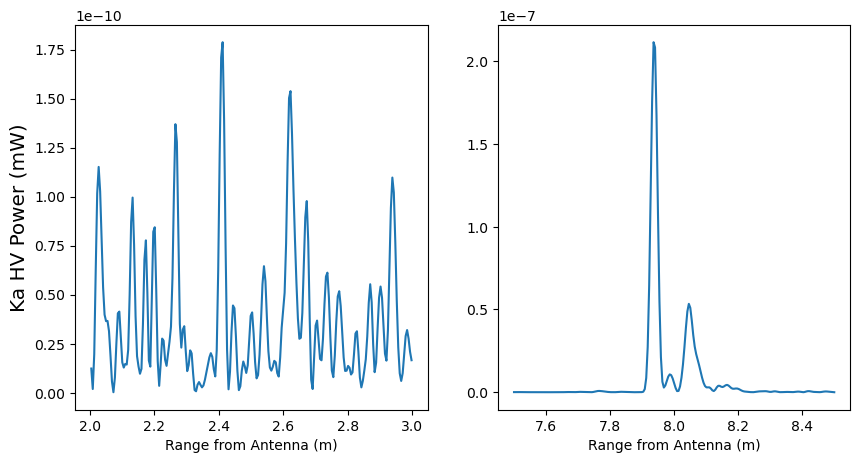

In [132]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

q0 = p[:,xmax-1][(ranges>2) & (ranges<3)]
r0 = ranges[(ranges>2) & (ranges<3)]

a0 = argrelmax(q0)
max_vals0 = q0[a0]
max_rs0 = r0[a0]

q1 = p[:,0][(ranges>7.5) & (ranges<8.5)]
r1 = ranges[(ranges>7.5) & (ranges<8.5)]

a1 = argrelmax(q1)
max_vals1 = q1[a1]
max_rs1 = r1[a1]

ax1.plot(r0,q0)
ax2.plot(r1,q1)

ax1.set_ylabel(f'{freqname} {polname.upper()} Power (mW)',fontsize='x-large')

for ax in [ax1,ax2]:
    ax.set_xlabel('Range from Antenna (m)')


In [133]:
df0 = pd.DataFrame({'v':max_vals1,'r':max_rs1})
df0.sort_values('v',inplace=True)
dfr = list(df0.iloc[-2:]['r'])
diff = dfr[0]-dfr[1]
diff

0.10986328125

In [134]:
df0 = pd.DataFrame({'v':max_vals0,'r':max_rs0})
df0.sort_values('v',inplace=True)
dfr = list(df0.iloc[-2:]['r'])
diff = dfr[0]-dfr[1]
diff

0.2105712890625

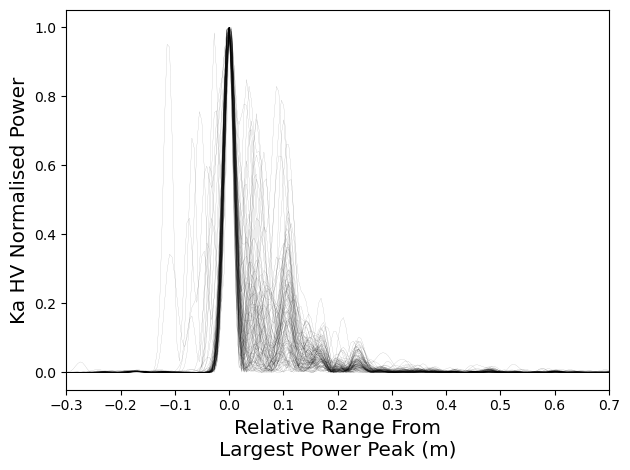

In [135]:
xi = np.linspace(-0.2,0.6,1000)

interped = []

for i in range(xmax):
    
    x = p[:,i][ranges>0]
    r = ranges[ranges>0]
    
    xnorm = x/np.max(x)
    
    rmax = r[np.argmax(x)]
    
    rnorm = r-rmax
    
    plt.plot(rnorm,xnorm,color='k',lw=0.1,alpha=0.5)
    
    interped.append( np.interp(xi,rnorm,xnorm) )
    
plt.xlim(-0.3,0.7)

plt.xticks(np.arange(-0.3,0.71,0.1))

plt.ylabel(f'{freqname} {polname.upper()} Normalised Power',fontsize='x-large')
plt.xlabel('Relative Range From\nLargest Power Peak (m)',fontsize='x-large')

plt.tight_layout()

plt.savefig(f'../figures/sidelobes_superimposed_{freqname}_{polname}.jpg',dpi=600)

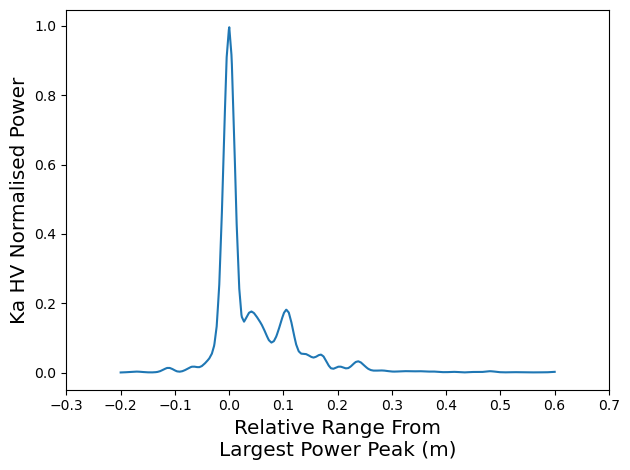

In [136]:
plt.plot(xi,np.sum(interped,axis=0)/xmax)

plt.ylabel(f'{freqname} {polname.upper()} Normalised Power',fontsize='x-large')
plt.xlabel('Relative Range From\nLargest Power Peak (m)',fontsize='x-large')
plt.xticks(np.arange(-0.3,0.71,0.1))
plt.savefig(f'../figures/sidelobes_averaged_{freqname}_{polname}.jpg',dpi=600)

plt.tight_layout()
plt.show()